#**Install Library**

In [46]:
!pip install basemap-data-hires
!pip install seaborn
!pip install basemap numpy pandas scipy
!pip install cartopy

#**Import Library**

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import linregress
import datetime
from datetime import datetime
import seaborn as sns


#**Read Dataset**

In [48]:
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset)
df.head(15)

# Konversi kolom 'time' ke format datetime
df['time'] = pd.to_datetime(df['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
df_selected = df[(df['time'].dt.year >= 1968) & (df['time'].dt.year <= 2018)]

# Tampilkan lima baris pertama dari data terpilih
df = df_selected
df.head(5)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1968-01-01 07:50:51.240000+00:00,32.958667,-115.863333,6.0,3.08,ml,5.0,166.0,0.7355,0.29,...,2016-01-28T19:54:48.710Z,"24km WSW of Westmorland, CA",earthquake,1.02,31.61,0.179,5.0,reviewed,ci,ci
1,1968-01-01 11:34:43.790000+00:00,33.468333,-120.179500,6.0,2.59,mh,4.0,302.0,1.0440,0.63,...,2016-01-28T19:37:37.050Z,"53km S of Santa Rosa Is., CA",earthquake,5.56,31.61,0.306,12.0,reviewed,ci,ci
2,1968-01-02 09:50:46.470000+00:00,35.705167,-118.039000,6.0,3.09,ml,8.0,84.0,0.3567,0.71,...,2016-01-28T19:33:22.000Z,"22km WNW of Inyokern, CA",earthquake,1.78,31.61,0.155,11.0,reviewed,ci,ci
3,1968-01-02 11:01:19.830000+00:00,35.740667,-118.060833,6.0,2.88,ml,10.0,97.0,0.3452,0.52,...,2016-01-28T19:59:01.740Z,"25km WNW of Inyokern, CA",earthquake,1.13,31.61,0.167,9.0,reviewed,ci,ci
4,1968-01-04 06:12:39.730000+00:00,35.111000,-119.085833,6.0,2.59,ml,9.0,146.0,0.2834,0.45,...,2016-01-28T19:54:49.210Z,"23km SW of Lamont, CA",earthquake,1.03,31.61,0.136,6.0,reviewed,ci,ci


In [49]:
# Mengambil hanya kolom yang diinginkan
selected_columns = ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'net', 'id', 'updated', 'type', 'status', 'locationSource', 'magSource']
df_selected_columns = df[selected_columns]

# Menampilkan DataFrame yang hanya berisi kolom yang dipilih
df_selected_columns.head(10)

,time,latitude,longitude,depth,mag,magType,net,id,updated,type,status,locationSource,magSource
0,1968-01-01 07:50:51.240000+00:00,32.958667,-115.863333,6.00,3.08,ml,ci,ci3329310,2016-01-28T19:54:48.710Z,earthquake,reviewed,ci,ci
1,1968-01-01 11:34:43.790000+00:00,33.468333,-120.179500,6.00,2.59,mh,ci,ci3342099,2016-01-28T19:37:37.050Z,earthquake,reviewed,ci,ci
2,1968-01-02 09:50:46.470000+00:00,35.705167,-118.039000,6.00,3.09,ml,ci,ci3329312,2016-01-28T19:33:22.000Z,earthquake,reviewed,ci,ci
3,1968-01-02 11:01:19.830000+00:00,35.740667,-118.060833,6.00,2.88,ml,ci,ci3329313,2016-01-28T19:59:01.740Z,earthquake,reviewed,ci,ci
4,1968-01-04 06:12:39.730000+00:00,35.111000,-119.085833,6.00,2.59,ml,ci,ci3329314,2016-01-28T19:54:49.210Z,earthquake,reviewed,ci,ci
5,1968-01-04 06:19:26.850000+00:00,35.118333,-119.099167,6.00,2.37,ml,ci,ci3329315,2016-01-28T19:50:28.820Z,earthquake,reviewed,ci,ci
6,1968-01-04 11:37:09.810000+00:00,32.276000,-117.088833,6.00,3.31,ml,ci,ci3329317,2016-01-28T19:37:37.540Z,earthquake,reviewed,ci,ci
7,1968-01-05 10:50:56.490000+00:00,35.687500,-118.114000,6.00,2.84,ml,ci,ci3329319,2016-01-28T19:41:48.200Z,earthquake,reviewed,ci,ci
8,1968-01-06 00:26:00.650000+00:00,35.089833,-119.059167,5.00,3.01,ml,ci,ci3329320,2016-01-28T19:41:48.730Z,earthquake,reviewed,ci,ci
9,1968-01-09 23:06:13.520000+00:00,34.863833,-118.734833,0.38,2.21,mh,ci,ci3329322,2016-01-28T19:59:02.950Z,earthquake,reviewed,ci,ci


In [50]:
def bvalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()

    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return b*(-1)

def generate_GR_Adeli_Panakkat_features(earthquake_dataset, time_window):
    earthquake_dataset['b-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=bvalue_OLS,raw = False).shift(1)
    return earthquake_dataset

In [65]:
california_region = df[df.mag >= 3.0].reset_index(drop = True)

In [71]:
california_region = generate_GR_Adeli_Panakkat_features(california_region, 60)

In [72]:
california_region.tail()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,b-value,year
1310,2018-08-29 02:33:28.330000+00:00,34.136333,-117.774667,5.46,4.38,mw,208.0,16.0,0.03385,0.26,...,earthquake,0.11,0.48,NaN,6.0,reviewed,ci,ci,1.162491,2018
1311,2018-09-29 02:17:46.720000+00:00,32.347667,-115.184000,28.67,4.41,mw,34.0,172.0,0.10180,0.29,...,earthquake,0.74,0.41,NaN,6.0,reviewed,ci,ci,1.164700,2018
1312,2018-11-19 20:18:42.510000+00:00,32.206500,-115.253500,10.95,4.82,mw,29.0,149.0,0.21680,0.38,...,earthquake,0.79,31.61,NaN,6.0,reviewed,ci,ci,1.167696,2018
1313,2018-11-27 13:07:12.830000+00:00,36.073500,-120.188167,10.80,4.00,mw,92.0,51.0,0.06483,0.11,...,earthquake,0.18,0.32,NaN,5.0,reviewed,nc,nc,1.156856,2018
1314,2018-12-05 21:40:16.620000+00:00,35.730333,-117.077667,0.84,4.20,mw,60.0,34.0,0.23160,0.17,...,earthquake,0.13,0.61,NaN,6.0,reviewed,ci,ci,1.150175,2018


#**Variasi Temporal nilai b**

In [73]:
df = california_region
# Mengonversi kolom 'time' ke tipe data datetime
df['time'] = pd.to_datetime(df['time'])

# Menambahkan kolom 'year' yang berisi tahun dari kolom 'time'
df['year'] = df['time'].dt.year

# Menampilkan lima baris pertama DataFrame
df.head(5)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,b-value,year
0,1968-03-28 21:21:33+00:00,34.046167,-116.080333,6.0,4.13,ml,14.0,157.0,0.4991,0.62,...,earthquake,1.74,31.61,0.081,11.0,reviewed,ci,ci,NaN,1968
1,1968-04-09 02:28:59.610000+00:00,33.179833,-116.103000,10.0,6.60,mw,15.0,128.0,0.6012,0.33,...,earthquake,0.88,31.61,NaN,0.0,reviewed,ci,ci,NaN,1968
2,1968-04-09 02:33:09+00:00,33.166667,-116.116667,0.0,4.30,mh,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,0.0,reviewed,ci,ci,NaN,1968
3,1968-04-09 02:39:28.520000+00:00,33.166667,-116.116667,6.0,4.23,ml,3.0,178.0,0.6020,2.26,...,earthquake,99.00,31.61,0.128,8.0,reviewed,ci,ci,NaN,1968
4,1968-04-09 03:03:51.090000+00:00,32.874667,-116.150167,6.0,5.20,mh,3.0,229.0,0.5117,0.33,...,earthquake,8.65,31.61,NaN,0.0,reviewed,ci,ci,NaN,1968


In [69]:
#reduksi kolom
fixkolom = california_region[['time','latitude', 'longitude', 'depth', 'mag','magType','year','b-value']]
fixkolom.head(10)

,time,latitude,longitude,depth,mag,magType,year,b-value
0,1968-03-28 21:21:33+00:00,34.046167,-116.080333,6.0,4.13,ml,1968,NaN
1,1968-04-09 02:28:59.610000+00:00,33.179833,-116.103000,10.0,6.60,mw,1968,NaN
2,1968-04-09 02:33:09+00:00,33.166667,-116.116667,0.0,4.30,mh,1968,NaN
3,1968-04-09 02:39:28.520000+00:00,33.166667,-116.116667,6.0,4.23,ml,1968,NaN
4,1968-04-09 03:03:51.090000+00:00,32.874667,-116.150167,6.0,5.20,mh,1968,NaN
5,1968-04-09 03:48:11.390000+00:00,33.068667,-116.025333,6.0,4.54,ml,1968,NaN
6,1968-04-09 03:58:36.060000+00:00,33.013333,-115.978833,6.0,4.14,ml,1968,NaN
7,1968-04-09 08:00:38.240000+00:00,32.998667,-115.980833,6.0,4.08,ml,1968,NaN
8,1968-04-09 18:31:04.210000+00:00,33.296333,-116.291500,14.0,4.45,ml,1968,NaN
9,1968-04-14 12:55:59.500000+00:00,33.229167,-116.218167,11.0,4.33,ml,1968,NaN


In [74]:
fixkolom = fixkolom.dropna()
fixkolom

,time,latitude,longitude,depth,mag,magType,year,b-value
30,1970-01-21 11:23:52.610000+00:00,32.319667,-115.978833,6.00,4.02,ml,1970,0.681853
31,1970-07-08 09:25:30.410000+00:00,35.419167,-117.791333,6.00,4.07,ml,1970,0.678936
32,1970-07-23 12:59:47.580000+00:00,32.011833,-115.943667,6.00,4.35,ml,1970,1.060287
33,1970-09-12 14:10:11.230000+00:00,34.258333,-117.501167,7.55,4.03,ml,1970,1.062106
34,1970-09-12 14:30:53+00:00,34.254833,-117.534333,10.75,5.22,ml,1970,1.041899
...,...,...,...,...,...,...,...,...
1310,2018-08-29 02:33:28.330000+00:00,34.136333,-117.774667,5.46,4.38,mw,2018,1.123098
1311,2018-09-29 02:17:46.720000+00:00,32.347667,-115.184000,28.67,4.41,mw,2018,1.130106
1312,2018-11-19 20:18:42.510000+00:00,32.206500,-115.253500,10.95,4.82,mw,2018,1.129029
1313,2018-11-27 13:07:12.830000+00:00,36.073500,-120.188167,10.80,4.00,mw,2018,1.110511


In [75]:
# Groupby & multiple aggregations
result = fixkolom.groupby('year')['b-value'].aggregate(['mean','min','max','sum'])

print(result)

          mean       min       max         sum
year                                          
1970  0.942381  0.678936  1.062106    6.596670
1971  0.820536  0.513127  1.288922   45.949993
1972  1.355624  1.172339  1.542542    5.422496
1973  1.070838  0.819809  1.552565   12.850062
1974  0.822108  0.809168  0.867731   13.153735
1975  1.183120  0.870700  1.737454   47.324782
1976  1.113766  1.021611  1.262523   21.161554
1977  1.202558  1.192751  1.215816    6.012791
1978  1.165788  1.086001  1.245730   13.989458
1979  0.774094  0.637683  1.140584   31.737857
1980  0.642937  0.561474  0.677836    5.143493
1981  0.648948  0.619524  0.677835    8.436323
1982  0.747492  0.656984  0.894982   17.192314
1983  0.705210  0.564386  1.020837   33.144873
1984  0.889083  0.835142  0.945265   13.336247
1985  1.071881  0.925755  1.182405   18.221969
1986  0.793523  0.702334  1.098436   16.663979
1987  0.629483  0.527119  0.782493   22.031913
1988  0.593306  0.548472  0.665807    8.899597
1989  0.96706

In [76]:
b_tot = fixkolom.groupby("year")["b-value"].sum()

b_ave = result["sum"].mean()

#**Temporal variation using values-b**

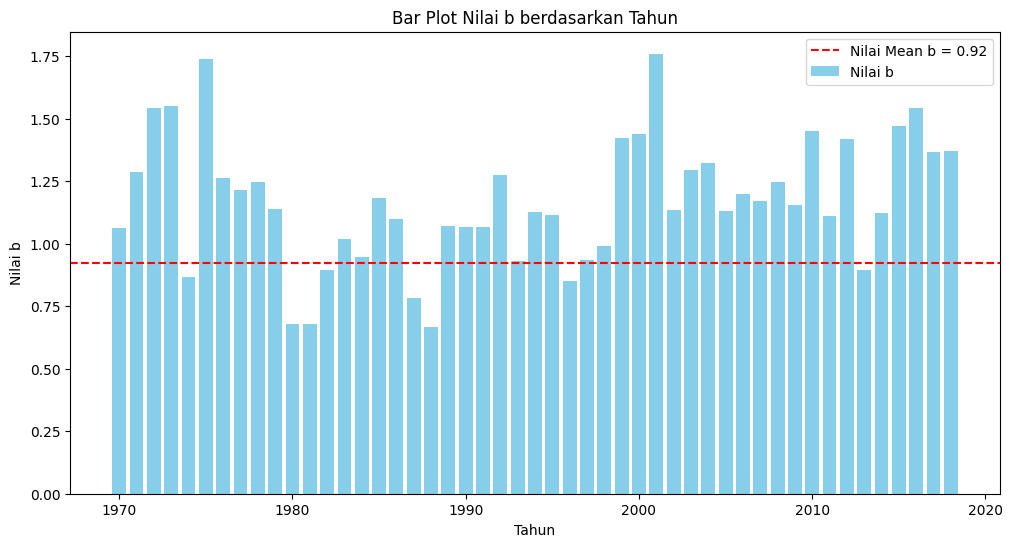

In [77]:
filtered_data = fixkolom[(fixkolom['year'] >= 1968) & (fixkolom['year'] <= 2018)]

# Hitung nilai mean dari b-value
mean_b_value = filtered_data['b-value'].mean()

# Plot bar plot
plt.figure(figsize=(12, 6))
plt.bar(filtered_data['year'], filtered_data['b-value'], color='skyblue', label='Nilai b')
plt.axhline(y=mean_b_value, color='red', linestyle='--', label=f'Nilai Mean b = {mean_b_value:.2f}')
plt.xlabel('Tahun')
plt.ylabel('Nilai b')
plt.title('Bar Plot Nilai b berdasarkan Tahun')
plt.legend()
plt.show()
